In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

In [6]:
methods = ['SVR', 'GB', 'RF']

In [125]:
dfs = {}
for method in methods:
    data_path = Path(method) / 'StatisticalArbitrage'
    folders = os.listdir(data_path)
    df = None
    for folder in folders:
        if '.' in folder:
            print(folder, 'is not a folder. Skipping...')
            continue
        temp = pd.read_csv(data_path / folder / 'totale.csv', index_col=0)
        temp['Date'] = pd.to_datetime(temp['Date'])
        temp['OC Percent'] = (temp['Close'] - temp['Open']) / temp['Open'] 

        col_pred = f'Predicted_OC_perc_{method}_mse_test'
        temp = temp.loc[:, ['Date', 'Title', 'OC Percent', col_pred]]
        temp.rename({col_pred: 'Pred_' + method}, inplace=True, axis=1)
        temp.set_index(['Date', 'Title'], inplace=True)
        if df is None:
            df = temp
        else:
            df = pd.concat([df, temp])
    dfs[method] = df

bias_variance.csv is not a folder. Skipping...
chosen_methods.csv is not a folder. Skipping...
bias_variance.csv is not a folder. Skipping...
chosen_methods.csv is not a folder. Skipping...


In [220]:
df = None
for method in methods:
    if df is None:
        df: pd.DataFrame = dfs[method]
    else:
        df = df.merge(dfs[method], how='inner', left_index=True, right_index=True)
df.sort_index(inplace=True)
# df

In [192]:
# combined signals - simple average across all models
df['Pred'] = df.filter(regex='Pred').mean(axis=1)

In [193]:
def rolling_accuracy(group: pd.DataFrame, lookback: int, method: str = None):
    col = 'Pred' if method is None else f'Pred_{method}'
    s: pd.Series = (np.sign(group['OC Percent']) == np.sign(group[col])).astype(int)
    return s.rolling(lookback).mean()

def calc_returns(group: pd.DataFrame, method: str = None, transaction_cost: float = 0.004) -> float:
    positions: pd.Series = get_positions(group, method=method)
    returns: pd.Series  = positions * group['OC Percent']
    return returns[returns != 0].mean() - transaction_cost

def get_positions(group: pd.DataFrame, min_accuracy: float = 0.5, method: str = None) -> pd.Series:
    col_pred = 'Pred' if method is None else f'Pred_{method}'
    col_acc = 'Accuracy' if method is None else f'Accuracy_{method}'
    temp: pd.Series = (group[group[col_acc] >= min_accuracy][col_pred].rank(method='min', ascending=False) <= 5).astype(int) + (group[group[col_acc] >= min_accuracy][col_pred].rank(method='min', ascending=True) <= 5).astype(int) * -1
    temp.name = 'Position'
    return group.merge(temp.to_frame('Position'), how='left', left_index=True, right_index=True).fillna(0)['Position']

In [194]:
for method in methods:
    df = df.merge(df.groupby('Title').apply(lambda group: rolling_accuracy(group, lookback=30, method=method)).fillna(0.5).to_frame(f'Accuracy_{method}').droplevel(level=0), how='inner', left_index=True, right_index=True)
df = df.merge(df.groupby('Title').apply(lambda group: rolling_accuracy(group, lookback=30, method=None)).fillna(0.5).to_frame('Accuracy').droplevel(level=0), how='inner', left_index=True, right_index=True)

<Axes: title={'center': 'number of stocks with 30D rolling pred accuracy >= 50%'}, xlabel='Date'>

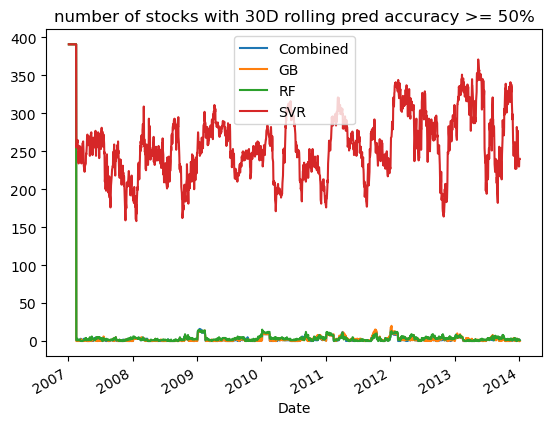

In [217]:
pd.DataFrame({
    'Combined': df.groupby('Date').apply(lambda group: len(group[group['Accuracy'] >= 0.5])), 
    'GB': df.groupby('Date').apply(lambda group: len(group[group['Accuracy_GB'] >= 0.5])),
    'RF': df.groupby('Date').apply(lambda group: len(group[group['Accuracy_RF'] >= 0.5])),
    'SVR': df.groupby('Date').apply(lambda group: len(group[group['Accuracy_SVR'] >= 0.5])),
}).plot(title='number of stocks with 30D rolling pred accuracy >= 50%')

<Axes: xlabel='Date'>

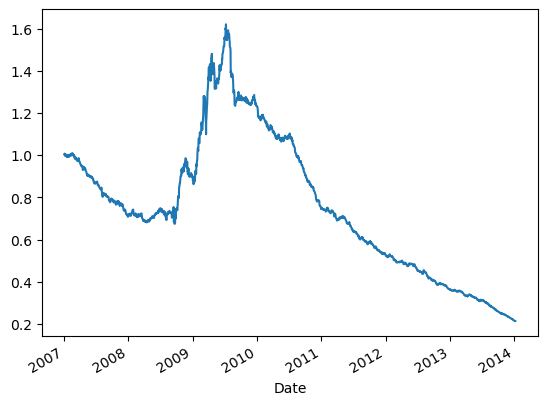

In [219]:
(1+df.groupby('Date').apply(lambda group: calc_returns(group, method='SVR', transaction_cost=0.004))).cumprod().plot()